In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pip install transformers==3.1.0

     |████████████████████████████████| 890kB 11.4MB/s 
     |████████████████████████████████| 3.0MB 53.8MB/s 
     |████████████████████████████████| 1.1MB 46.8MB/s 
     |████████████████████████████████| 890kB 46.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c0a456deb17c27c095c8453745e59d9a0b942289875064a1e51eabce2aa8d70b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import sys
sys.path.append(<insert the drive folder containing the project>)

# **Training**

Insert the required parameters in the config file.

In [ ]:
import os
import time
import shutil
import time
import json
import random
import time
import argparse
import numpy as np

## torch packages
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from transformers import get_linear_schedule_with_warmup

## for visualisation
import matplotlib.pyplot as plt

## custom
from eval import eval_model
from select_model_input import select_model,select_input
import dataset
import config as train_config
from label_dict import label_emo_map

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)



def save_checkpoint(state, is_best,filename='checkpoint.pth.tar'):
    torch.save(state,filename)
    if is_best:
        shutil.copyfile(filename,filename.replace('checkpoint.pth.tar','model_best.pth.tar'))

def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)



def train_epoch(model, train_iter, epoch,loss_fn,optimizer,config):
    
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    steps = 0
    model.train()
    start_train_time = time.time()
    for idx, batch in enumerate(train_iter):

        text, attn, target = select_input(batch,config,arch_name)
        target = torch.autograd.Variable(target).long()
        print(text[0].size())
        if (target.size()[0] is not config.batch_size):# Last batch may have length different than config.batch_size
            continue
        
        if torch.cuda.is_available():
          if arch_name =="kea_electra" or arch_name == "kea_bert":
                text = [text[0].cuda(),text[1].cuda(),text[2].cuda(),text[3].cuda()]
          else:
            text = text.cuda()
          attn = attn.cuda()
          target = target.cuda()

        ## model prediction
        model.zero_grad()
        optimizer.zero_grad()
        # print("Prediction")
        prediction = model(text,attn)
        # print("computing loss")
        loss = loss_fn(prediction, target)

        ## evaluation
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/config.batch_size
        # print("Loss backward")
        startloss = time.time()
        loss.backward()
        # print(time.time()-startloss,"Finish loss")
        clip_gradient(model, 1e-1)
        # torch.nn.utils.clip_grad_norm_(model.parameters(),1)
        optimizer.step()
        # print("=====================")
        steps += 1
        if steps % 100 == 0:
            print (f'Epoch: {epoch+1:02}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%, Time taken: {((time.time()-start_train_time)/60): .2f} min')
            start_train_time = time.time()

        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def train_model(config,data,model,loss_fn,optimizer,lr_scheduler,writer,save_home):

    best_acc1 = 0
    patience_flag = 0
    train_iter,valid_iter,test_iter = data[0],data[1],data[2] # data is a tuple of three iterators

    # print("Start Training")
    for epoch in range(config.start_epoch,config.nepoch):

        ## train and validation
        train_loss, train_acc = train_epoch(model, train_iter, epoch,loss_fn,optimizer,config)

        val_loss, val_acc ,val_f1_score,val_w_f1_score,val_top3_acc= eval_model(model, valid_iter,loss_fn,config,arch_name)
        print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')
        ## testing
        test_loss, test_acc,test_f1_score,test_w_f1_score,test_top3_acc = eval_model(model, test_iter,loss_fn,config,arch_name)
        print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}% Test F1 score: {test_f1_score:.4f}')

        ## save best model
        is_best = val_acc > best_acc1
        os.makedirs(save_home,exist_ok=True)
        save_checkpoint({'epoch': epoch + 1,'arch': arch_name,'state_dict': model.state_dict(),'train_acc':train_acc,"val_acc":val_acc,'param':log_dict["param"],'optimizer' : optimizer.state_dict(),},is_best,save_home+"/checkpoint.pth.tar")

        best_acc1 = max(val_acc, best_acc1)
        if config.step_size != None:
          lr_scheduler.step()

        ## tensorboard runs
        writer.add_scalar('Loss/train',train_loss,epoch)
        writer.add_scalar('Accuracy/train',train_acc,epoch)
        writer.add_scalar('Loss/val',val_loss,epoch)
        writer.add_scalar('Accuracy/val',val_acc,epoch)

        ## save logs
        if is_best:


            patience_flag = 0
            log_dict["train_acc"] = train_acc
            log_dict["test_acc"] = test_acc
            log_dict["valid_acc"] = val_acc
            log_dict["test_f1_score"] = test_f1_score
            log_dict["valid_f1_score"] = val_f1_score
            log_dict["top3_acc"] = test_top3_acc
            log_dict["train_loss"] = train_loss
            log_dict["test_loss"] = test_loss
            log_dict["valid_loss"] = val_loss
            log_dict["epoch"] = epoch+1
            log_dict["note"] = note
            log_dict["weighted_test_f1_score"] = test_w_f1_score
            log_dict["weighted_valid_f1_score"] = val_w_f1_score


            with open(save_home+"/log.json", 'w') as fp:
                json.dump(log_dict, fp,indent=4)
            fp.close()
        else:
            patience_flag += 1

        ## early stopping
        if patience_flag == config.patience or epoch == config.nepoch-1:
            print(log_dict)
            break


if __name__ == '__main__':

    # note = "without dom" ## to note any changes
    log_dict = {}
    log_dict["param"] = train_config.param
    print(train_config.learning_rate)
    print(train_config.arch_name)
    print(train_config.batch_size)
    ## Loading data
    print('Loading dataset')
    start_time = time.time()
    vocab_size, word_embeddings,train_iter, valid_iter ,test_iter= dataset.get_dataloader(train_config.batch_size,train_config.tokenizer,train_config.embedding_type,train_config.arch_name)

    data = (train_iter,valid_iter,test_iter)
    finish_time = time.time()
    print('Finished loading. Time taken:{:06.3f} sec'.format(finish_time-start_time))
    if train_config.tuning:

    ## Initialising parameters from train_config

        for lr in [1e-05,2e-05,3e-05]: ## for tuning 
          learning_rate = lr
          arch_name = train_config.arch_name
          log_dict["param"]["learning_rate"] = lr
          log_dict["param"]["arch_name"] = arch_name
          note = "Tuning learning_rate:"+str(lr)

          # learning_rate = train_config.learning_rate

          

          input_type = train_config.input_type

          ## Initialising model, loss, optimizer, lr_scheduler
          model = select_model(train_config,arch_name,vocab_size,word_embeddings)
          loss_fn = nn.CrossEntropyLoss()
          total_steps = len(train_iter) * train_config.nepoch

          optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learning_rate)
          if train_config.step_size != None:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,train_config.step_size, gamma=0.5)


          ## Filepaths for saving the model and the tensorboard runs
          model_run_time = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
          writer = SummaryWriter('./runs/'+input_type+"/"+arch_name+"/")
          save_home = "./save/"+input_type+"/"+arch_name+"/"+model_run_time

          train_model(train_config,data,model,loss_fn,optimizer,lr_scheduler,writer,save_home)
    else:
        learning_rate = train_config.learning_rate

        arch_name = train_config.arch_name

        input_type = train_config.input_type
       
        ## Initialising model, loss, optimizer, lr_scheduler
        model = select_model(train_config,arch_name,vocab_size,word_embeddings)
        loss_fn = nn.CrossEntropyLoss()
        total_steps = len(train_iter) * train_config.nepoch

        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learning_rate)


        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,train_config.step_size, gamma=0.5)



        ## Filepaths for saving the model and the tensorboard runs
        model_run_time = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
        writer = SummaryWriter('/content/gdrive/My Drive/emotion_recognition/runs/'+input_type+"/"+arch_name+"/")
        save_home = "/content/gdrive/My Drive/emotion_recognition/save/"+input_type+"/"+arch_name+"/"+model_run_time


        train_model(train_config,data,model,loss_fn,optimizer,lr_scheduler,writer,save_home)



# **Evaluation** 

Insert model path and log path to run the evaluation

Loading dataset
Finished loading. Time taken:03.894 sec


Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'electra.embeddings_project.weight', 'electra.embeddings_project.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at goo

encoder.electra.embeddings.position_ids torch.Size([1, 512])
encoder.electra.embeddings.word_embeddings.weight torch.Size([30522, 768])
encoder.electra.embeddings.position_embeddings.weight torch.Size([512, 768])
encoder.electra.embeddings.token_type_embeddings.weight torch.Size([2, 768])
encoder.electra.embeddings.LayerNorm.weight torch.Size([768])
encoder.electra.embeddings.LayerNorm.bias torch.Size([768])
encoder.electra.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
encoder.electra.encoder.layer.0.attention.self.query.bias torch.Size([768])
encoder.electra.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
encoder.electra.encoder.layer.0.attention.self.key.bias torch.Size([768])
encoder.electra.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
encoder.electra.encoder.layer.0.attention.self.value.bias torch.Size([768])
encoder.electra.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
encoder.electra.encoder.layer.

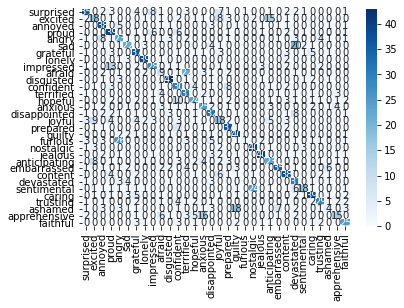

Test Accuracy of surprised: 48% (35/72)
Test Accuracy of excited: 32% (18/56)
Test Accuracy of annoyed: 70% (38/54)
Test Accuracy of proud: 67% (39/58)
Test Accuracy of angry: 44% (23/52)
Test Accuracy of   sad: 40% (22/55)
Test Accuracy of grateful: 64% (37/57)
Test Accuracy of lonely: 84% (39/46)
Test Accuracy of impressed: 51% (28/54)
Test Accuracy of afraid: 20% ( 9/44)
Test Accuracy of disgusted: 79% (43/54)
Test Accuracy of confident: 58% (30/51)
Test Accuracy of terrified: 68% (31/45)
Test Accuracy of hopeful: 45% (24/53)
Test Accuracy of anxious: 51% (25/49)
Test Accuracy of disappointed: 59% (32/54)
Test Accuracy of joyful: 31% (18/57)
Test Accuracy of prepared: 74% (37/50)
Test Accuracy of guilty: 81% (40/49)
Test Accuracy of furious:  2% ( 1/48)
Test Accuracy of nostalgic: 80% (40/50)
Test Accuracy of jealous: 72% (40/55)
Test Accuracy of anticipating: 46% (23/49)
Test Accuracy of embarrassed: 60% (35/58)
Test Accuracy of content: 65% (38/58)
Test Accuracy of devastated: 68%

In [ ]:
import os
import time
import shutil
import time
import json
import random
import numpy as np
from easydict import EasyDict as edict
import argparse
from sklearn.metrics import classification_report,f1_score
import pickle

## torch packages
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

## for visulisation
import matplotlib.pyplot as plt

## custom
from select_model_input import select_model,select_input
import dataset
from label_dict import emo_label_map,label_emo_map,class_names,class_indices

# from xai_emo_rec import explain_model
# from comparison import do_comparison

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

def accuracy_topk(output, target, topk=(3,)):
    """ Taken fromhttps://discuss.pytorch.org/t/imagenet-example-accuracy-calculation/7840/2
    Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    # print(pred,target)
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res[0].item()

def get_pred_softmax(logits):
    softmax_layer = nn.Softmax(dim=1)
    return softmax_layer(logits)

def eval_model(model, val_iter, loss_fn,config,arch_name,mode="train",explain=False):

    confusion = config.confusion
    per_class = config.per_class
    y_true = []
    y_pred = []
    total_epoch_loss = 0
    total_epoch_acc = 0
    total_epoch_acc3 = 0

    eval_batch_size = 1

    if confusion:
        conf_matrix = torch.zeros(config.output_size, config.output_size)
    if per_class:
           class_correct = list(0. for i in range(config.output_size))
           class_total = list(0. for i in range(config.output_size))

    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            model = model.cuda()
            text, attn,target = select_input(batch,config,arch_name)
            target = torch.autograd.Variable(target).long()

            if torch.cuda.is_available():
              if arch_name =="kea_electra" or arch_name == "kea_bert":
                text = [text[0].cuda(),text[1].cuda(),text[2].cuda(),text[3].cuda()]
              else:
                text = text.cuda()
              attn = attn.cuda()
              target = target.cuda()

            prediction = model(text,attn)

            correct = np.squeeze(torch.max(prediction, 1)[1].eq(target.view_as(torch.max(prediction, 1)[1])))
            pred_ind = torch.max(prediction, 1)[1].view(target.size()).data

            if mode == "explain":
                pred_softmax = get_pred_softmax(prediction)
                explain_model(model,text,target.data,batch["utterance_data_str"],pred_ind,pred_softmax) ## use jupyter-notebook while doing explainations
            else:
                if confusion:
                    for t, p in zip(target.data, pred_ind):
                            conf_matrix[t.long(), p.long()] += 1
                if per_class:
                    label = target[0]
                    class_correct[label] += correct.item()
                    class_total[label] += 1

                loss = loss_fn(prediction, target)

                num_corrects = (pred_ind == target.data).sum()
                y_true.extend(target.data.cpu().tolist())
                y_pred.extend(pred_ind.cpu().tolist())

                acc = 100.0 * num_corrects/eval_batch_size
                acc3 = accuracy_topk(prediction, target, topk=(3,))
                total_epoch_loss += loss.item()
                total_epoch_acc += acc.item()
                total_epoch_acc3 += acc3

        if confusion:
            import seaborn as sns
            sns.heatmap(conf_matrix, annot=True,xticklabels=list(emo_label_map.keys()),yticklabels=list(emo_label_map.keys()),cmap='Blues')

            plt.show()
        if per_class:
            for i in range(config.output_size):
                print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                label_emo_map[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))

    if mode != "explain":

        f1_score_e = f1_score(y_true, y_pred, labels=class_indices,average='macro')
        f1_score_w = f1_score(y_true, y_pred, labels=class_indices,average='weighted')
        return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter),f1_score_e,f1_score_w,total_epoch_acc3/len(val_iter)



def load_model(resume,model,optimizer):


    checkpoint = torch.load(resume)
    start_epoch = checkpoint['epoch']
    # for i,v in checkpoint["state_dict"].items():
    #     print(i,v.size())
    model.load_state_dict(checkpoint['state_dict'])
    model = model.cuda()
    model.eval()
    optimizer.load_state_dict(checkpoint['optimizer']) ## during retrain TODO

    return model,optimizer,start_epoch



if __name__ == '__main__':

    # parser = argparse.ArgumentParser(description='Enter eval details')

    # parser.add_argument('-r','--resume_path',type=str,help='Input resume path')
    # parser.add_argument('-m','--mode',default='eval',type=str,help='Input resume path')
    # parser.add_argument('-n','--rem_epoch',default=10,type=int,help='How much more epochs to run')
    # parser.add_argument('-p','--patience',default=10,type=int,help='Early stopping patience')
    # parser.add_argument('-c','--compare_model',default="",type=str,help='Provide resume path of the comparing model')

    # args = parser.parse_args()

    resume_path = "" ## insert model path
    log_path = "" ## insert log path
    mode = "eval"
    rem_epoch = 10 # only for retraining TODO
    patience = ""
    comp_resume_path = "" # for comparison 
    ## Load the resume model parameters
    # log_path = resume_path.replace("model_best.pth.tar","log.json")
    with open(log_path,'r') as f:
        log = json.load(f)
    f.close()

    if mode == "compare":
        do_comparison(resume_path,comp_resume_path)
        exit()

    ## Initialising parameters
    learning_rate = log["param"]["learning_rate"]
    batch_size = 1 ## batch_size=1 for testing and validation
    input_type = log["param"]["input_type"]
    arch_name = log["param"]["arch_name"]
    hidden_size = log["param"]["hidden_size"]
    embedding_length = log["param"]["embedding_length"]
    output_size = log["param"]["output_size"]
    tokenizer = log["param"]["tokenizer"]
    embedding_type = log["param"]["embedding_type"]

    ## Loading data
    print('Loading dataset')
    start_time = time.time()
    vocab_size, word_embeddings,train_iter, valid_iter ,test_iter= dataset.get_dataloader(batch_size,tokenizer,embedding_type,arch_name)
    finish_time = time.time()
    print('Finished loading. Time taken:{:06.3f} sec'.format(finish_time-start_time))

    eval_config = edict(log["param"])
    eval_config.param = log["param"]
    eval_config.resume_path = resume_path
    eval_config.batch_size = 1  ## batch_size=1 for testing and validation

    if mode == "explain":
        model = select_model(eval_config,vocab_size,word_embeddings,grad_check=False)
    else:
        model = select_model(eval_config,arch_name,vocab_size,word_embeddings)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,eval_config.step_size, gamma=0.5)

    model,optimizer,start_epoch = load_model(resume_path,model,optimizer)

    if mode == "retrain": ## retrain from checkpoint TODO
        from train import train_model
        eval_config.patience = patience
        eval_config.nepoch = rem_epoch
        eval_config.confusion = False
        eval_config.per_class = True
        eval_config.start_epoch = start_epoch

        data  = (train_iter,valid_iter,test_iter)
        model_run_time = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
        writer = SummaryWriter('./runs/'+input_type+"/"+arch_name+"/")
        save_home = "./save/"+input_type+"/"+arch_name+"/"+model_run_time

        train_model(eval_config,data,model,loss_fn,optimizer,lr_scheduler,writer,save_home)

    elif mode == "eval":

        print(f'Train Acc: {log["train_acc"]:.3f}%, Valid Acc: {log["valid_acc"]:.3f}%, Test Acc: {log["test_acc"]:.3f}%')

        eval_config.confusion = True
        eval_config.per_class = True

        ## testing

        test_loss, test_acc,test_f1_score,test_f1_score_w,test_top3_acc= eval_model(model, test_iter,loss_fn,eval_config,arch_name,mode)
        print(test_acc)
        print(f'Top3 Acc: {test_top3_acc:.3f}%, F1 Score: {test_f1_score:.3f}, F1 Score W: {test_f1_score_w:.3f}')


    elif mode == "explain":

        print(f'Train Acc: {log["train_acc"]:.3f}%, Valid Acc: {log["valid_acc"]:.3f}%, Test Acc: {log["test_acc"]:.3f}%')

        eval_config.confusion = False
        eval_config.per_class = False

        ## explaining
        eval_model(model, test_iter,loss_fn,eval_config,arch_name,mode,explain=True)
